In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from inference import YOLOInference

In [4]:
def middleCrop(image_path, percentage):
    """
    Crops the middle of an image.

    Args:
        image_path (str): The path to the input image.

    Returns:
        numpy.ndarray: The cropped image, or None if the image cannot be loaded.
    """
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not load image from {image_path}")
        return None
    
    if percentage >= 1:
        return img

    height, width = img.shape[:2]

    # Calculate the dimensions of the 10% middle section
    crop_height = int(height * percentage)
    crop_width = int(width * percentage)
    # crop_height = crop_width

    # Calculate the starting and ending coordinates for the crop
    start_y = (height - crop_height) // 2
    end_y = start_y + crop_height
    start_x = (width - crop_width) // 2
    end_x = start_x + crop_width

    # Perform the crop using NumPy array slicing
    cropped_img = img[start_y:end_y, start_x:end_x]

    return cropped_img

# Naive detection

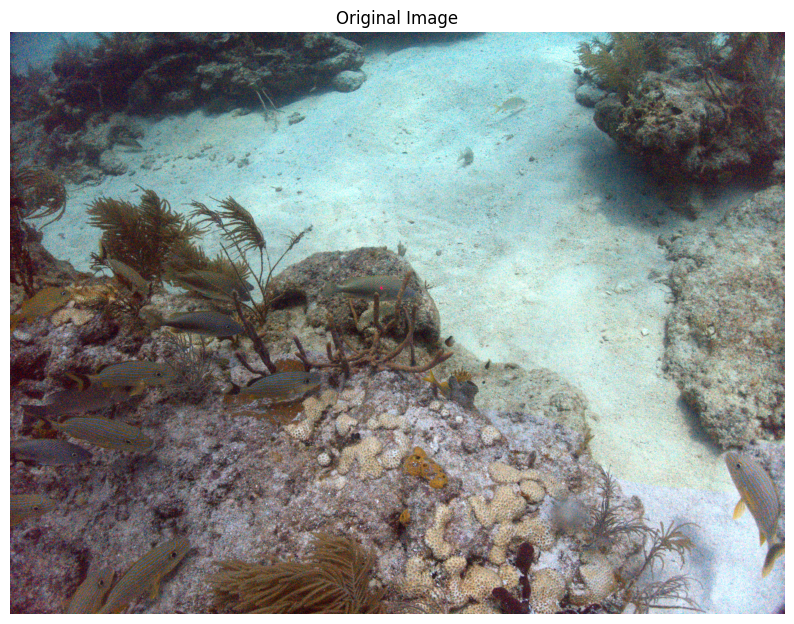

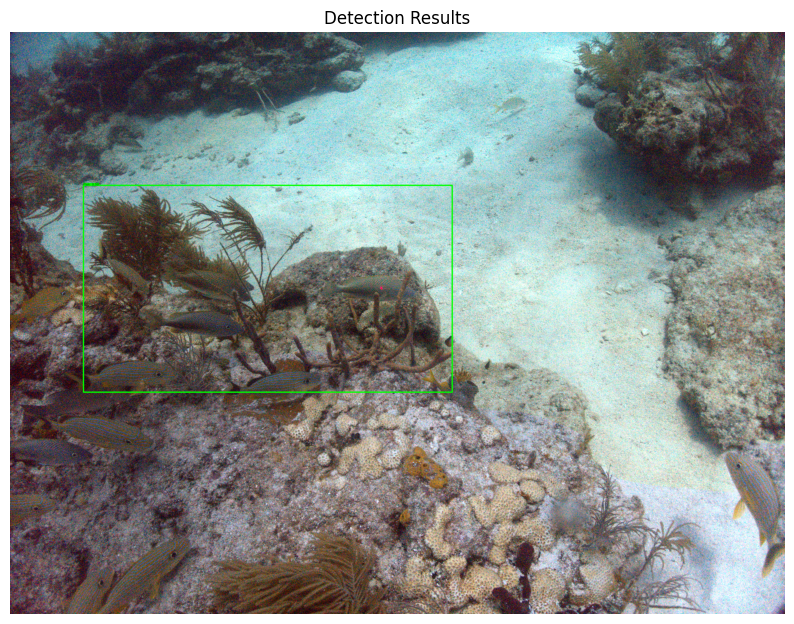

Image dimensions:  4014 x 3016
Found 1 fish in the image:

Fish 1:
- Bounding box: (380, 798, 2290, 1868)
- Confidence: 0.5898
- Area: 2043700 pixels


In [ ]:
import matplotlib.pyplot as plt
from inference import YOLOInference

model_path = "model.ts"
detector = YOLOInference(model_path, imsz=(640, 640), conf_threshold=0.5, yolo_ver='v8')

image = middleCrop("P8010068UIE.png", 1)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')
plt.show()

results = detector.predict(image)
output_image = image.copy()

for detection in results[0]:
    # Draw bounding box
    detection.draw_box(output_image, color=(0, 255, 0), thickness=5)
    
    # Draw label with confidence score
    label = f"Fish: {detection.score:.2f}"
    detection.draw_label(output_image, label, color=(0, 255, 0))

# Convert to RGB for display
output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

# Display results
plt.figure(figsize=(10, 10))
plt.imshow(output_image_rgb)
plt.title("Detection Results")
plt.axis('off')
plt.show()

# Print detection details
height, width, channels = image.shape
print("Image dimensions: ", width, "x", height)
print(f"Found {len(results[0])} fish in the image:")
for i, detection in enumerate(results[0], 1):
    print(f"\nFish {i}:")
    print(f"- Bounding box: {detection.get_box()}")
    print(f"- Confidence: {detection.score:.4f}")
    print(f"- Area: {detection.get_area()} pixels")

# Color enhancements

In [ ]:
import numpy as np

def gray_world_balance_clipped(img, clip_percent=10, min_brightness=50):
    img = img.astype(np.float32)
    balanced = img.copy()

    # Per-channel Gray World balancing with clipping
    for c in range(3):  # For B, G, R
        channel = img[:, :, c].flatten()
        sorted_vals = np.sort(channel)
        n = len(sorted_vals)
        lower_idx = int(n * (clip_percent / 100))
        upper_idx = int(n * (1 - (clip_percent / 100)))
        clipped = sorted_vals[lower_idx:upper_idx]

        channel_mean = np.mean(clipped)
        overall_mean = np.mean(img)
        scale = overall_mean / channel_mean
        balanced[:, :, c] *= scale

    # Brightness rescaling
    gray = cv2.cvtColor(balanced.astype(np.uint8), cv2.COLOR_BGR2GRAY)
    current_mean = np.mean(gray)
    if current_mean < min_brightness:
        brightness_scale = min_brightness / current_mean
        balanced *= brightness_scale

    return np.clip(balanced, 0, 255).astype(np.uint8)

def equalize_color_histogram(img):
    img_y_cr_cb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    img_y_cr_cb[:, :, 0] = cv2.equalizeHist(img_y_cr_cb[:, :, 0])
    return cv2.cvtColor(img_y_cr_cb, cv2.COLOR_YCrCb2BGR)

def white_patch_color_correction(image, white_patch_percentile=99):
    image_float = image.astype(np.float32)

    # Calculate the scaling factors for each color channel
    white_values = np.percentile(image_float, white_patch_percentile, axis=(0, 1))
    scaling_factors = 255.0 / white_values

    # Apply the scaling to the image
    corrected_image = image_float * scaling_factors

    # Clip the values to the valid range (0-255) and convert back to uint8
    corrected_image = np.clip(corrected_image, 0, 255).astype(np.uint8)

    return corrected_image

# Zoom-out approach

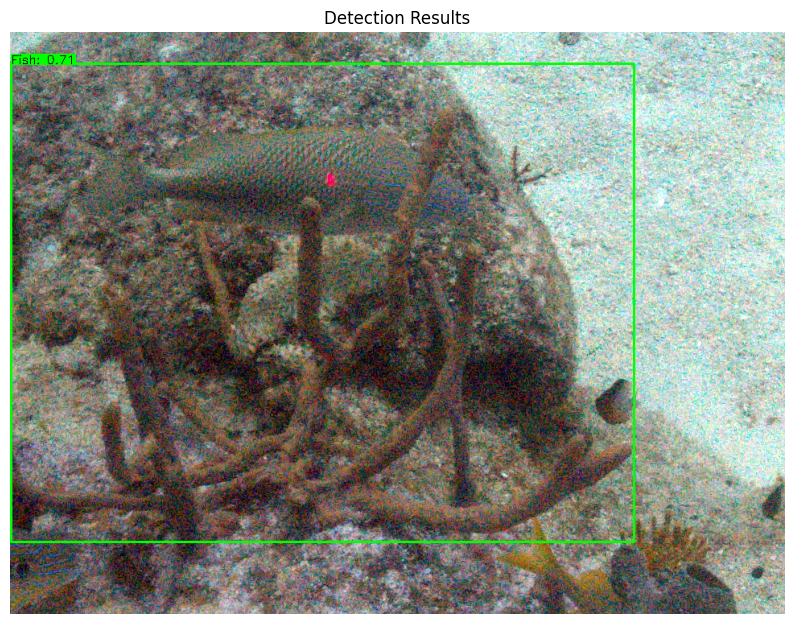

i = 24
Image dimensions:  1043 x 784
Found 1 fish in the image:

Fish 1:
- Bounding box: (1, 39, 775, 633)
- Confidence: 0.7149
- Area: 459756 pixels


In [ ]:
image_path = "P8010068UIE.png"
model_path = "model.ts"

detector = YOLOInference(model_path, imsz=(640, 640), conf_threshold=0.5, yolo_ver='v8')

old = 0.0
new = 0.0
detected = False
best = 5

# Iterate over increasing crop sizes
for i in range (16, 101, 2):
    image = middleCrop(image_path, (i*0.01))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image_rgb = gray_world_balance_clipped(image_rgb)
    # image_rgb = equalize_color_histogram(image_rgb)
    # image_rgb = white_patch_color_correction(image_rgb)
    
    results = detector.predict(image)

    if len(results) > 0:
        detected = True
    else:
        detected = False

    # Keep zooming out while improving
    old = new
    if detected:
        max = 0.0
        for result in results[0]:
            if result.score > max:
                max = result.score
        new = max
    else:
        new = 0.0

    if (old > new):
        break

    best = i

output_image = middleCrop(image_path, (best*0.01))
results = detector.predict(output_image)

for detection in results[0]:
    # Draw bounding box
    detection.draw_box(output_image, color=(0, 255, 0), thickness=2)
    
    # Draw label with confidence score
    label = f"Fish: {detection.score:.2f}"
    detection.draw_label(output_image, label, color=(0, 255, 0))

# Convert to RGB for display
output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
# output_image_rgb = gray_world_balance_clipped(output_image_rgb)
# output_image_rgb = equalize_color_histogram(output_image_rgb)
# image_rgb = white_patch_color_correction(image_rgb)

# Display results
plt.figure(figsize=(10, 10))
plt.imshow(output_image_rgb)
plt.title("Detection Results")
plt.axis('off')
plt.show()

# Print detection details
print("i = " + str(best))
height, width, channels = image.shape
print("Image dimensions: ", width, "x", height)
print(f"Found {len(results[0])} fish in the image:")
for i, detection in enumerate(results[0], 1):
    print(f"\nFish {i}:")
    print(f"- Bounding box: {detection.get_box()}")
    print(f"- Confidence: {detection.score:.4f}")
    print(f"- Area: {detection.get_area()} pixels")

# Zoom-in approach

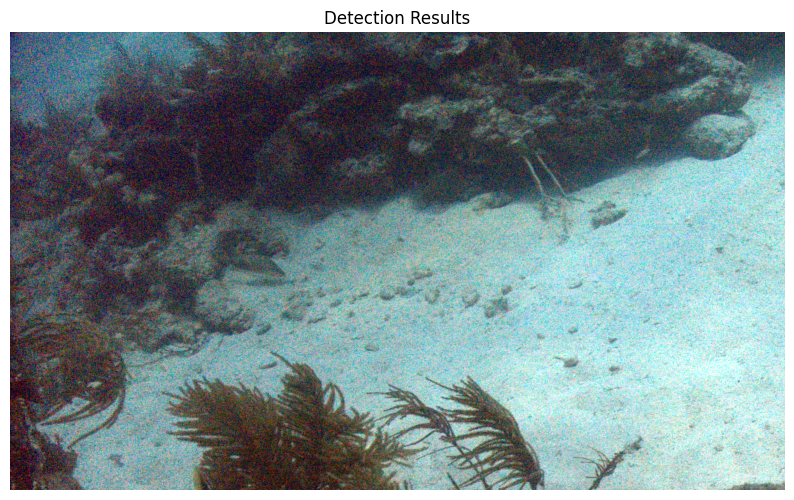

bbox = (5, 2, 1921, 1134)
Image dimensions:  4014 x 3016
Found 0 fish in the image:


In [ ]:
image_path = "P8010068UIE.png"
model_path = "model.ts"
detector = YOLOInference(model_path, imsz=(640, 640), conf_threshold=0.5, yolo_ver='v8')

image = middleCrop(image_path, 1)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width, channels = image.shape

old = 0.0
new = 0.0
detected = True
bbox = (0, 0, height, width)
best = (0, 0, height, width)

# Iteratively predict on previous detection
while detected:
    x_min, y_min, x_max, y_max = bbox
    cropped = image_rgb[y_min:y_max, x_min:x_max]
    
    results = detector.predict(cropped)

    if len(results) > 0:
        detected = True
    else:
        detected = False

    old = new
    if detected:
        max = 0.0
        for result in results[0]:
            if result.score > max:
                max = result.score
                bbox = result.get_box()
        new = max
    else:
        new = 0.0

    if (old > new):
        break

    best = bbox

x_min, y_min, x_max, y_max = best
final = image_rgb[y_min:y_max, x_min:x_max]

results = detector.predict(final)

# Display results
plt.figure(figsize=(10, 10))
plt.imshow(final)
plt.title("Detection Results")
plt.axis('off')
plt.show()

# Print detection details
print("bbox = " + str(best))
height, width, channels = image.shape
print("Image dimensions: ", width, "x", height)
print(f"Found {len(results[0])} fish in the image:")
for i, detection in enumerate(results[0], 1):
    print(f"\nFish {i}:")
    print(f"- Bounding box: {detection.get_box()}")
    print(f"- Confidence: {detection.score:.4f}")
    print(f"- Area: {detection.get_area()} pixels")

# Depth map detection experiments

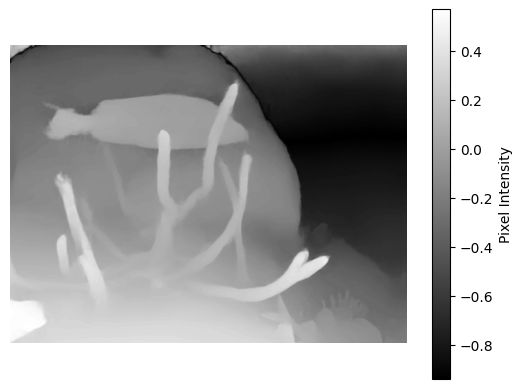

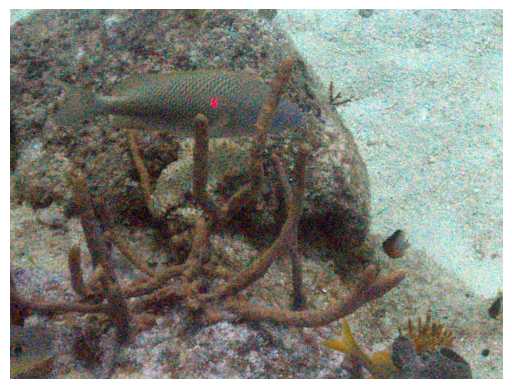

In [19]:
# Use depth map as a contrast mask
image = middleCrop("P8010068UIE.png", .24)
depth = middleCrop("cropdepth.png", 1)
# depth = cv2.resize(depth, (231, 173), interpolation=cv2.INTER_AREA)

rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(depth, cv2.COLOR_BGR2GRAY)

lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
l, a, b = cv2.split(lab)

gray_norm = gray.astype(np.float32) / 255.0
gray_inverted = 1.0 - gray_norm

mask = (gray_inverted - 0.5) * 2
mask = np.clip(mask, -1, 1)

l = l.astype(np.float32)
l = l + mask * 10 # brightness factor
l = np.clip(l, 0, 255).astype(np.uint8)

lab = cv2.merge([l, a, b])
merged = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

# multiplied = np.clip(rgb.astype(np.float32) * (0.5 + gray_inverted[..., None]), 0, 255).astype(np.uint8)

cv2.imwrite("merged.png", cv2.cvtColor(merged, cv2.COLOR_RGB2BGR))

plt.imshow(mask, cmap='gray')
plt.colorbar(label='Pixel Intensity')
plt.axis('off')
plt.show()
plt.imshow(merged)
plt.axis('off')
plt.show()

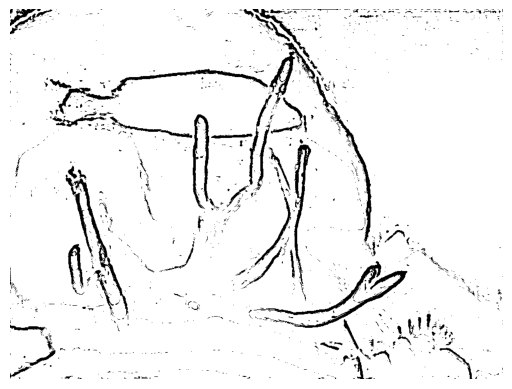

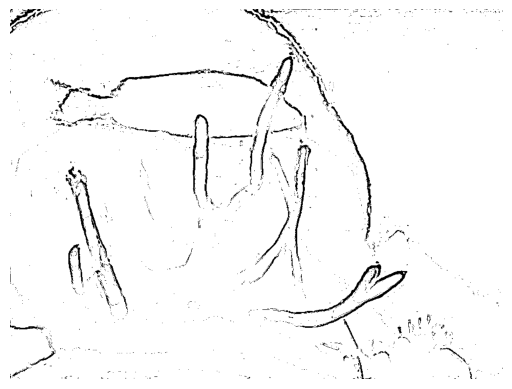

In [ ]:
# Calculate edges using thresholding
depth = middleCrop("cropdepth.png", 1)
gray = cv2.cvtColor(depth, cv2.COLOR_BGR2GRAY)

mean = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)

gauss = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

plt.imshow(mean, cmap='gray')
plt.axis('off')
plt.show()
plt.imshow(gauss, cmap='gray')
plt.axis('off')
plt.show()

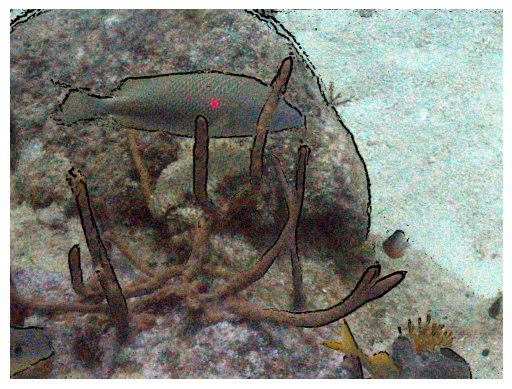

In [ ]:
# Sharpen image edges
image = middleCrop("P8010068UIE.png", .24)

edge = cv2.bitwise_and(image, image, mask=gauss)

edge = cv2.cvtColor(edge, cv2.COLOR_BGR2RGB)

cv2.imwrite("outline_gauss.png", cv2.cvtColor(edge, cv2.COLOR_RGB2BGR))

plt.imshow(edge)
plt.axis('off')
plt.show()